# Extract and filter tide gauge data

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


0.275956536867153
7032.31640351667
-----
1.1408910624436464
6723.301752677108
-----
6.638848455147672
6813.479264865859
-----
4.890842655363048
6964.985078037658
-----
4.237280966430287
6875.265394470241
-----
Selected Locations: ['Bermagui', 'Crookhaven_Heads', 'Port_Macquarie', 'Coffs_Harbour', 'Brunswick_Heads']
Locations: {'Bermagui': {'latitude': -36.42633887, 'longitude': 150.0715333}, 'Crookhaven_Heads': {'latitude': -34.9066, 'longitude': 150.7592}, 'Port_Macquarie': {'latitude': -31.42679171, 'longitude': 152.9109833}, 'Coffs_Harbour': {'latitude': -30.30285837, 'longitude': 153.1460611}, 'Brunswick_Heads': {'latitude': -28.53681115, 'longitude': 153.55211}}


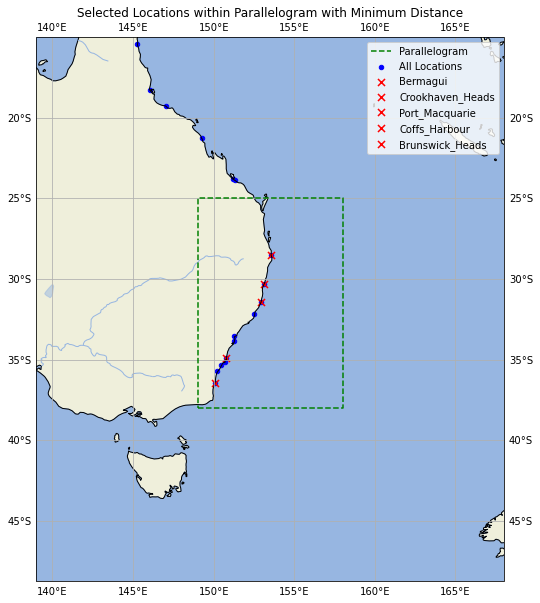

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.path import Path
import math
from shapely.geometry import Point, LineString, MultiLineString
import os
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt
from fuzzywuzzy import process
from ctw_functions import butter_bandpass, butter_bandpass_filter, interpolate_nan, find_nearest_non_nan



# Function to calculate distance using the Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c
    return distance

# Function to check if points are inside a polygon
def points_in_polygon(points, polygon):
    path = Path(polygon)
    return path.contains_points(points)

# Function to filter points to ensure a minimum distance between them
def filter_by_distance(coords, min_distance_km):
    filtered_coords = []
    for coord in coords:
        if all(haversine(coord['longitude'], coord['latitude'], fc['longitude'], fc['latitude']) >= min_distance_km for fc in filtered_coords):
            filtered_coords.append(coord)
    return filtered_coords

# Function to calculate distance from coastline
def distance_from_coastline(lon, lat, coastline):
    point = Point(lon, lat)
    min_distance = float('inf')
    for geom in coastline:
        if isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                distance = geom.distance(point) * 111  # Convert degrees to kilometers
            else:  # MultiLineString
                distance = min(line.distance(point) for line in geom.geoms) * 111  # Convert degrees to kilometers
            if distance < min_distance:
                min_distance = distance
    return min_distance

# Function to calculate distance from rivers
def distance_from_river(lon, lat, rivers):
    point = Point(lon, lat)
    min_distance = float('inf')
    for geom in rivers:
        if isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                distance = geom.distance(point) * 111  # Convert degrees to kilometers
            else:  # MultiLineString
                distance = min(line.distance(point) for line in geom.geoms) * 111  # Convert degrees to kilometers
            if distance < min_distance:
                min_distance = distance
    return min_distance


# Choose the dates
start_date='2023-08-29'
end_date='2023-11-30'


# Choose the region
region = 'EAST_AUSTRALIA'


# # # EAST_AUSTRALIA
# # parallelogram_vertices = np.array([
# #     [149, -38],  # Bottom-left
# #     [158, -38],  # Bottom-right
# #     [158, -25],  # Top-right
# #     [149, -25]   # Top-left
# # ])

# # # NORWAY
# # parallelogram_vertices = np.array([
# #     [5, 58],  # Bottom-left
# #     [7, 58],  # Bottom-right
# #     [20, 70],  # Top-right
# #     [5, 70]   # Top-left
# # ])

# # # NORTH_WEST_AMERICA
# # parallelogram_vertices = np.array([
# #     [-119, 32],  # Bottom-left
# #     [-116, 32],  # Bottom-right
# #     [-123, 47],  # Top-right
# #     [-127, 47]   # Top-left
# # ])

# NORTH_EAST_AMERICA
# parallelogram_vertices = np.array([
#     [-80, 24],  # Bottom-left
#     [-79.05, 26.2],  # Bottom-right
#     [-74, 47],  # Top-right
#     [-84, 36.06]   # Top-left
# ])


# Define the vertices of the parallelogram for EAST_AUSTRALIA
parallelogram_vertices = np.array([
    [149, -38],  # Bottom-left
    [158, -38],  # Bottom-right
    [158, -25],  # Top-right
    [149, -25]   # Top-left
])


# Load the dataset
#file_path = '/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2004_selected_lowess_dac_correctedglobal.nc'
file_path = '/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2023_selected_lowess_dac_correctedaustralia.nc'

ds = xr.open_dataset(file_path)

# Subsample the dataset based on the date range
ds = ds.sel(date_time=slice(start_date, end_date))

# Extract the relevant variables
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
site_names = ds['site_name'].values

# Combine latitudes and longitudes into a single array of points
points = np.vstack((longitudes, latitudes)).T

# Filter locations based on the parallelogram
selected_indices = points_in_polygon(points, parallelogram_vertices)

selected_sites = site_names[selected_indices]
selected_coords = [{
    'site_name': site_name,
    'latitude': latitudes[i],
    'longitude': longitudes[i]
} for i, site_name in enumerate(site_names) if selected_indices[i]]

# Filter the selected coordinates to ensure a minimum distance of 50 km
min_distance_km = 50
filtered_coords = filter_by_distance(selected_coords, min_distance_km)

# Load coastline data
coastline = list(cfeature.COASTLINE.geometries())
rivers = list(cfeature.RIVERS.geometries())

# Check if all geometries are valid
if not all(isinstance(geom, (LineString, MultiLineString)) for geom in coastline + rivers):
    print("Error: Some geometries are not LineString or MultiLineString.")



# Filter coordinates based on proximity to coastline (within 10 km) and not near river mouths (more than 1 km)
max_distance_km = 10
min_river_distance_km = 25
final_coords = []
for coord in filtered_coords:
    distance_to_coastline = distance_from_coastline(coord['longitude'], coord['latitude'], coastline)
    distance_to_river = distance_from_river(coord['longitude'], coord['latitude'], rivers)
    if distance_to_coastline <= max_distance_km and distance_to_river > min_river_distance_km:
        print(distance_to_coastline)
        print(distance_to_river)
        print('-----')
        final_coords.append(coord)

# Sort the final coordinates from south to north
final_coords_sorted = sorted(final_coords, key=lambda x: x['latitude'])

# Extract sorted site names and coordinates
selected_locations = [coord['site_name'] for coord in final_coords_sorted]
locations = {coord['site_name']: {'latitude': coord['latitude'], 'longitude': coord['longitude']} for coord in final_coords_sorted}

# Print selected locations and their coordinates
print("Selected Locations:", selected_locations)
print("Locations:", locations)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([np.min(parallelogram_vertices[:, 0]) - 10, np.max(parallelogram_vertices[:, 0]) + 10,
               np.min(parallelogram_vertices[:, 1]) - 10, np.max(parallelogram_vertices[:, 1]) + 10])

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot all locations
ax.scatter(longitudes, latitudes, color='blue', marker='o', s=20, transform=ccrs.PlateCarree(), label='All Locations')

# Highlight selected locations
for site_name in selected_locations:
    coord = locations[site_name]
    ax.scatter(coord['longitude'], coord['latitude'], color='red', marker='x', s=50, transform=ccrs.PlateCarree(), label=site_name)

# Plot the parallelogram
parallelogram_path = np.vstack((parallelogram_vertices, parallelogram_vertices[0]))
ax.plot(parallelogram_path[:, 0], parallelogram_path[:, 1], color='green', linestyle='--', transform=ccrs.PlateCarree(), label='Parallelogram')

# Add legend
ax.legend(loc='upper right')

# Add gridlines
ax.gridlines(draw_labels=True)

plt.title('Selected Locations within Parallelogram with Minimum Distance')
plt.show()

Shape of filtered_sla_dac_filtered: (94, 5)
Number of valid site names: 5


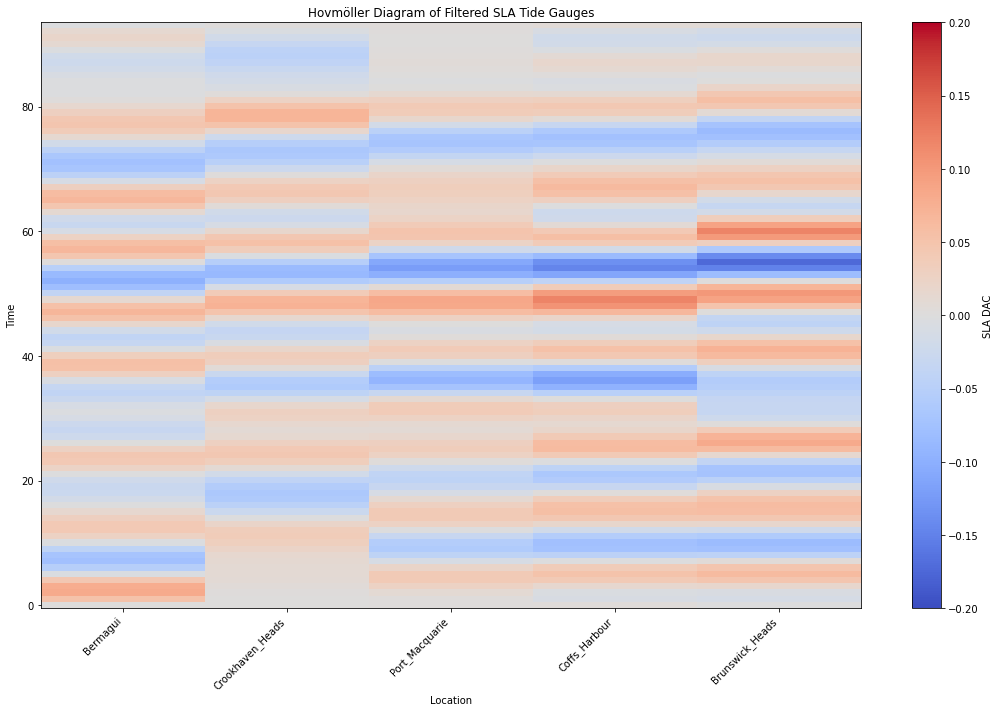

Latitude and Longitude for Selected Locations:
Bermagui: Latitude -36.42633887, Longitude 150.0715333
Crookhaven_Heads: Latitude -34.9066, Longitude 150.7592
Port_Macquarie: Latitude -31.42679171, Longitude 152.9109833
Coffs_Harbour: Latitude -30.30285837, Longitude 153.1460611
Brunswick_Heads: Latitude -28.53681115, Longitude 153.55211
Saved data to /DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_time_series_tidegauges/tide_gauge_data.npz


In [2]:


# Define the output directory
output_dir = '/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_time_series_tidegauges'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Load the dataset
dataset = xr.open_dataset(file_path)

# Subsample the dataset based on the date range
dataset = dataset.sel(date_time=slice(start_date, end_date))

# Convert hourly data to daily means
daily_dataset = dataset.resample(date_time='D').mean()

# Extract necessary variables
sla_dac = daily_dataset['sla_dac'].values
time = daily_dataset['date_time'].values
site_names = dataset['site_name'].values
latitudes = dataset['latitude'].values
longitudes = dataset['longitude'].values



# Frequency cutoffs in cycles per day
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day

# Find closest matches for selected locations in the dataset's site_names
filtered_indices = []
valid_site_names = []
valid_latitudes = []
valid_longitudes = []

for loc in selected_locations:
    match = process.extractOne(loc, site_names)
    if match[1] >= 80:  # Minimum similarity score threshold
        idx = np.where(site_names == match[0])[0][0]
        filtered_indices.append(idx)
        valid_site_names.append(match[0])
        valid_latitudes.append(latitudes[idx])
        valid_longitudes.append(longitudes[idx])
    else:
        print(f"No close match found for '{loc}'.")

# Filter sla_dac and reorder according to filtered indices
filtered_sla_dac = sla_dac[:, filtered_indices]

# Calculate the mean of each row
row_means = np.nanmean(filtered_sla_dac, axis=0)

# Subtract the row mean from each element in the row
filtered_sla_dac_demeaned = filtered_sla_dac - row_means[np.newaxis,:]

# Apply the Butterworth bandpass filter to each time series
filtered_sla_dac_filtered = []
for i in range(filtered_sla_dac.shape[1]):
    series = filtered_sla_dac[:, i]
    nan_count = np.isnan(series).sum()
    if nan_count <= 0.9 * len(time):  # Keep if less than or equal to 90% NaNs
        if nan_count > 0:
            series = interpolate_nan(series)
        series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)
        filtered_sla_dac_filtered.append(series)

filtered_sla_dac_filtered = np.array(filtered_sla_dac_filtered).T  # Transpose for correct shape

# Check the shapes of the data arrays
print("Shape of filtered_sla_dac_filtered:", filtered_sla_dac_filtered.shape)
print("Number of valid site names:", len(valid_site_names))

# Create the Hovmöller diagram using imshow with masked array
fig, ax = plt.subplots(figsize=(15, 10))

# Set normalization for the color scale
norm = Normalize(vmin=-0.2, vmax=0.2)

# Plot using imshow with masked array
im = ax.imshow(filtered_sla_dac_filtered, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)

# Set labels and title
ax.set_xlabel('Location')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of Filtered SLA Tide Gauges')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('SLA DAC')

# Set x-axis ticks and labels (locations)
ax.set_xticks(np.arange(len(valid_site_names)))
ax.set_xticklabels(valid_site_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Print latitude and longitude for each selected location
print("Latitude and Longitude for Selected Locations:")
for name, lat, lon in zip(valid_site_names, valid_latitudes, valid_longitudes):
    print(f"{name}: Latitude {lat}, Longitude {lon}")

# Save the filtered data and metadata externally
output_file = os.path.join(output_dir, 'tide_gauge_data.npz')
np.savez(output_file,
         filtered_sla_dac_demeaned=filtered_sla_dac_demeaned,
         filtered_sla_dac_filtered=filtered_sla_dac_filtered, 
         valid_site_names=valid_site_names, 
         valid_latitudes=valid_latitudes, 
         valid_longitudes=valid_longitudes)

print(f"Saved data to {output_file}")
